In [1]:
# Add repo root to sys.path so the package can be imported in-kernel without reinstalling
import sys
from pathlib import Path
repo_root = (Path('..').resolve())  # notebook is RTD_Calibration_VGP/notebooks
sys.path.insert(0, str(repo_root))
print('Inserted repo root into sys.path:', repo_root)

# Now you can import modules from the package via the package namespace
# e.g. from RTD_Calibration_VGP.src.run import Run if needed

Inserted repo root into sys.path: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration


In [2]:
# Import local modules via package namespace (repo root was inserted into sys.path earlier)
from RTD_Calibration_VGP.src.logfile import Logfile
from RTD_Calibration_VGP.src.run import Run
from pathlib import Path
import pandas as pd

# Read the logfile from the repository data folder (relative path from the notebook)
repo_root = Path('..').resolve()  # notebooks/.. -> RTD_Calibration_VGP
logfile_path = (repo_root / 'data' / 'LogFile.csv').resolve()
if not logfile_path.exists():
    print(f'Warning: logfile not found at {logfile_path}. Create or provide RTD_Calibration_VGP/data/LogFile.csv before running data processing cells.')
    logfile_df = pd.DataFrame()
else:
    logfiles = Logfile(filepath=str(logfile_path))  # This reads the CSV file
    logfile_df = logfiles.log_file  # Get the loaded DataFrame
    print("Logfile loaded:")
    print(logfile_df.head())  # Show the first rows of the DataFrame

ModuleNotFoundError: No module named 'RTD_Calibration_VGP'

In [ ]:
# 1. Load the logfile using the LogFile class (already loaded in the previous cell)
# Note: `logfile_df` was already defined in cell 1 as the absolute path to the file in data/LogFile.csv

# View the loaded logfile data (optional)
# print(logfile_df.head())

# 2. Name of the temperature file you want to process
filename = "20250924_ln2_r48177_r49264_58374-58398_3"

# 1. Create an instance of the Run class
run = Run(filename=filename, logfile=logfile_df)

# THESE ARE FUNCTIONS THAT ARE IN THE INIT AND ARE EXECUTED DIRECTLY WHEN CREATING THE INSTANCE
# 2. Load the temperature file
# run.load_temperature_file()
# run.filter_faulty_channels()
# 3. Associate the sensors with the temperature channels
# run.associate_sensors()

# 4. Print the DataFrame with the processed data
print("Temperature data with associated sensor IDs:")
print(run.temperature_data.head())  # Here you access the instance attribute directly

Archivo de temperatura encontrado: /Users/vicky/Desktop/rtd-calibration-ana/RTD_Calibration_VGP/data/temperature_files/RTD_Calibs/CalSetN_59/20250924_ln2_r48177_r49264_58374-58398_3.txt (buscado en: /Users/vicky/Desktop/rtd-calibration-ana/RTD_Calibration_VGP/data/temperature_files)
Valores NaN (contador): 0
Empty DataFrame
Columns: [datetime, channel, value]
Index: []
Archivo de temperatura procesado correctamente: /Users/vicky/Desktop/rtd-calibration-ana/RTD_Calibration_VGP/data/temperature_files/RTD_Calibs/CalSetN_59/20250924_ln2_r48177_r49264_58374-58398_3.txt
No se detectaron canales defectuosos.
Valores de sensores extraídos (antes de filtrado y conversión): [58374. 58400. 58399. 58371. 58373. 58372. 58366. 58367. 58401. 58375.
 58370. 58398. 48177. 49264.]
IDs de sensores después de la conversión: ['58374', '58400', '58399', '58371', '58373', '58372', '58366', '58367', '58401', '58375', '58370', '58398', '48177', '49264']
Asociación de canales con IDs de sensores:
channel_1: Sen

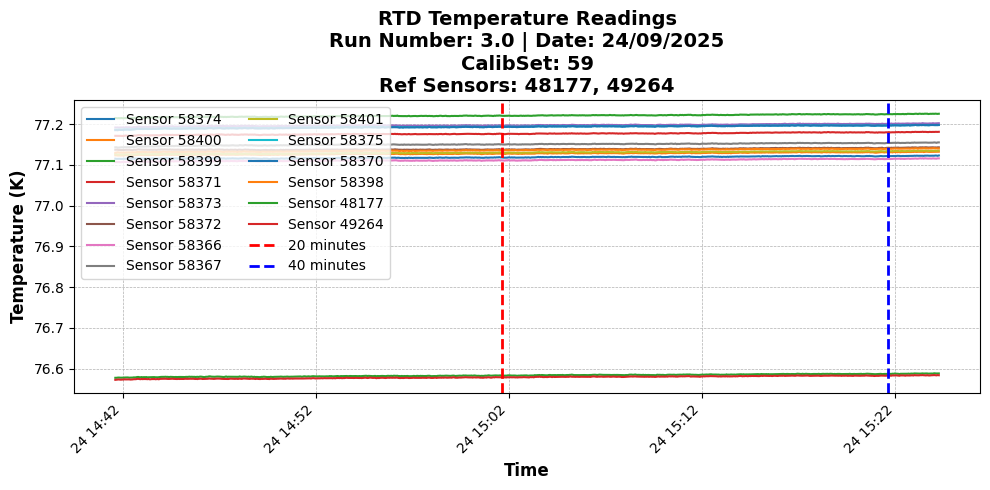

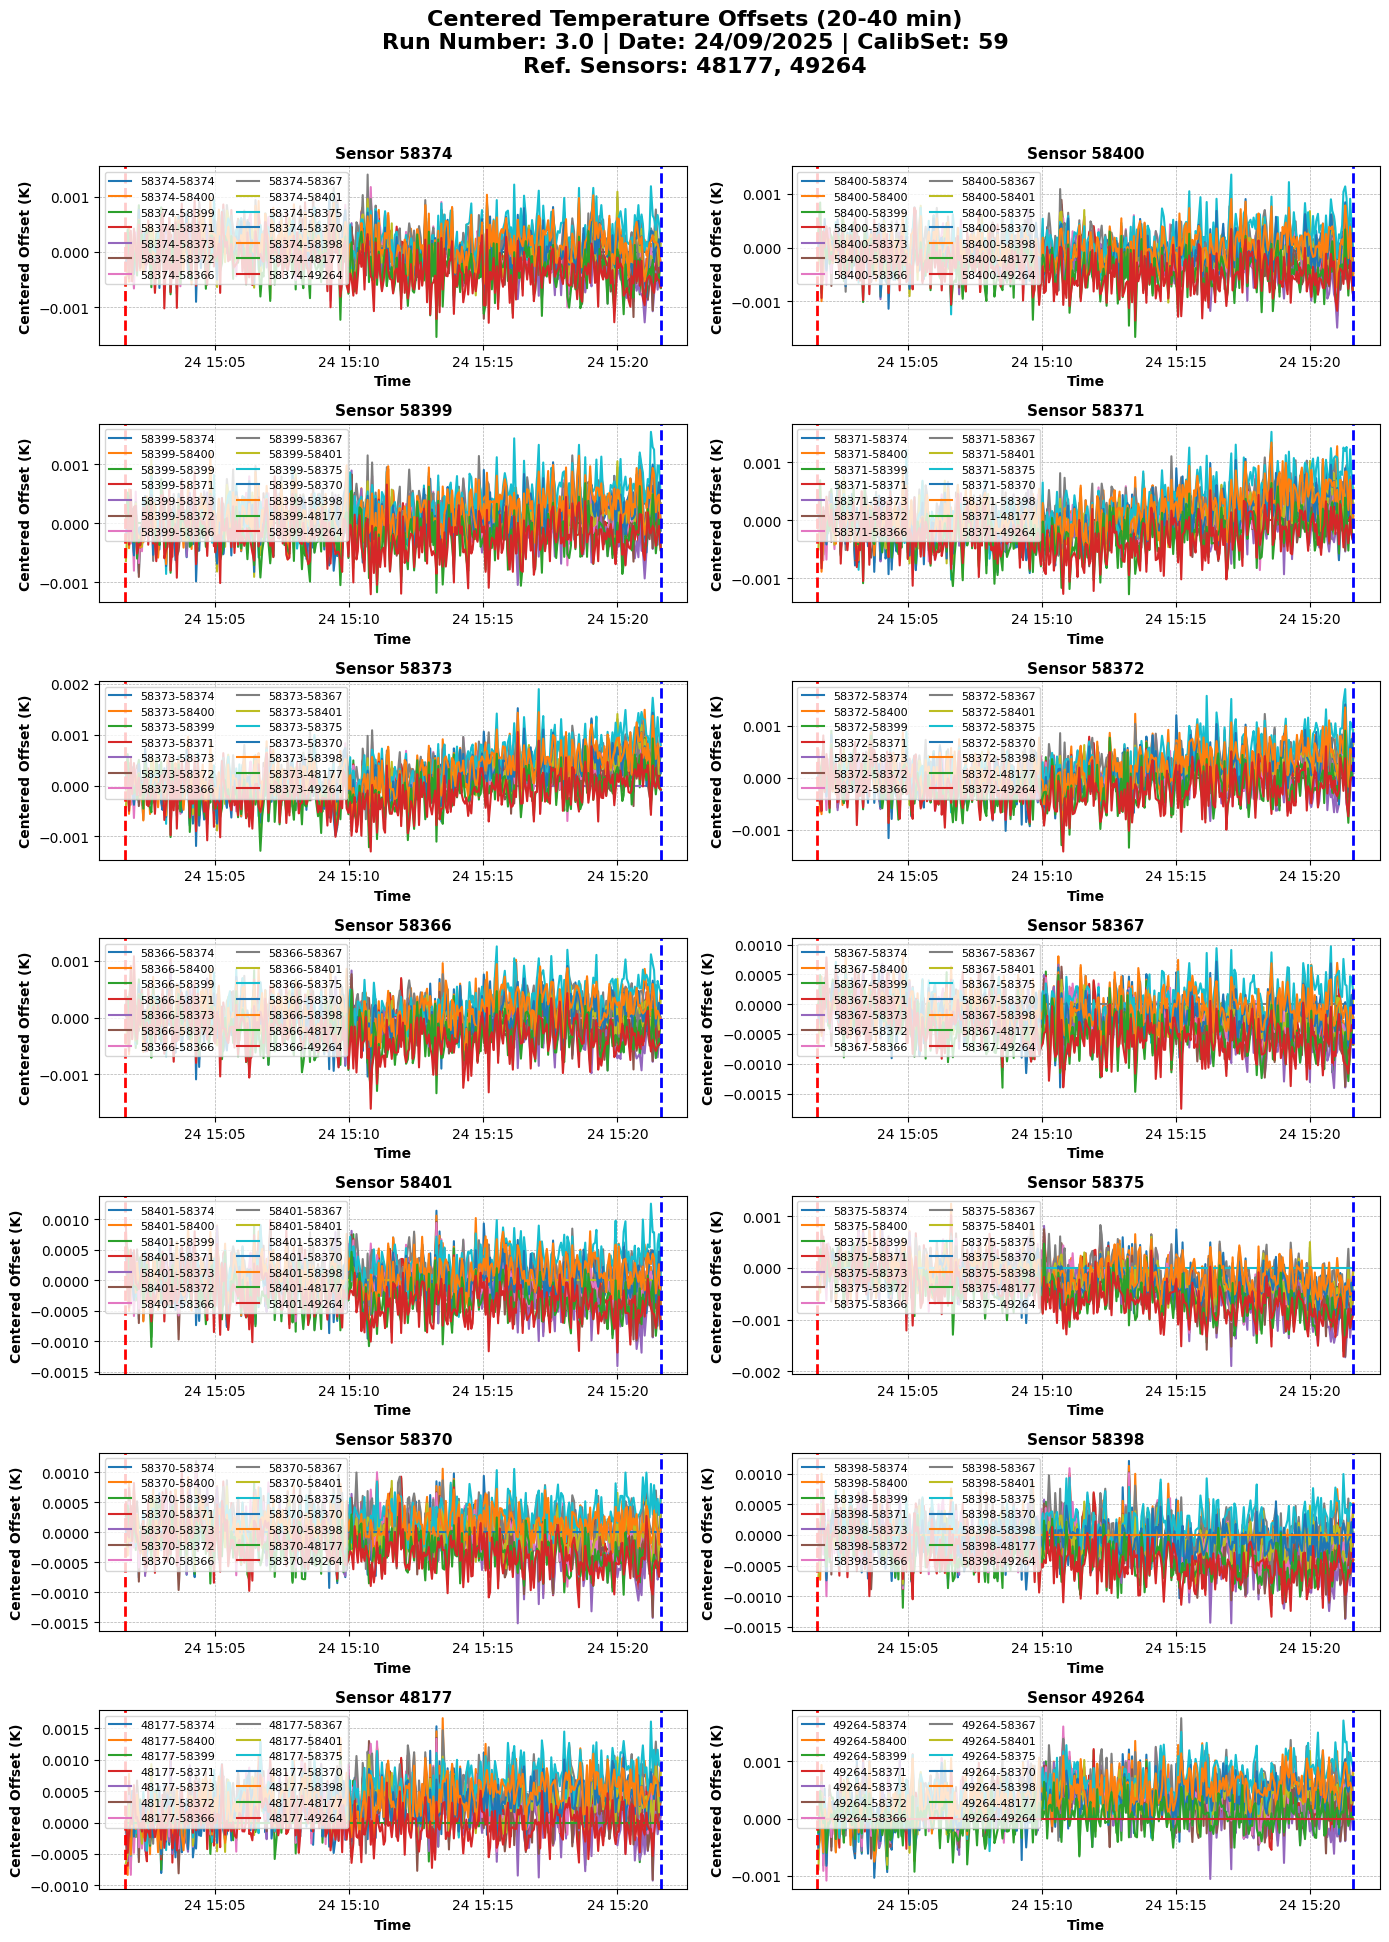

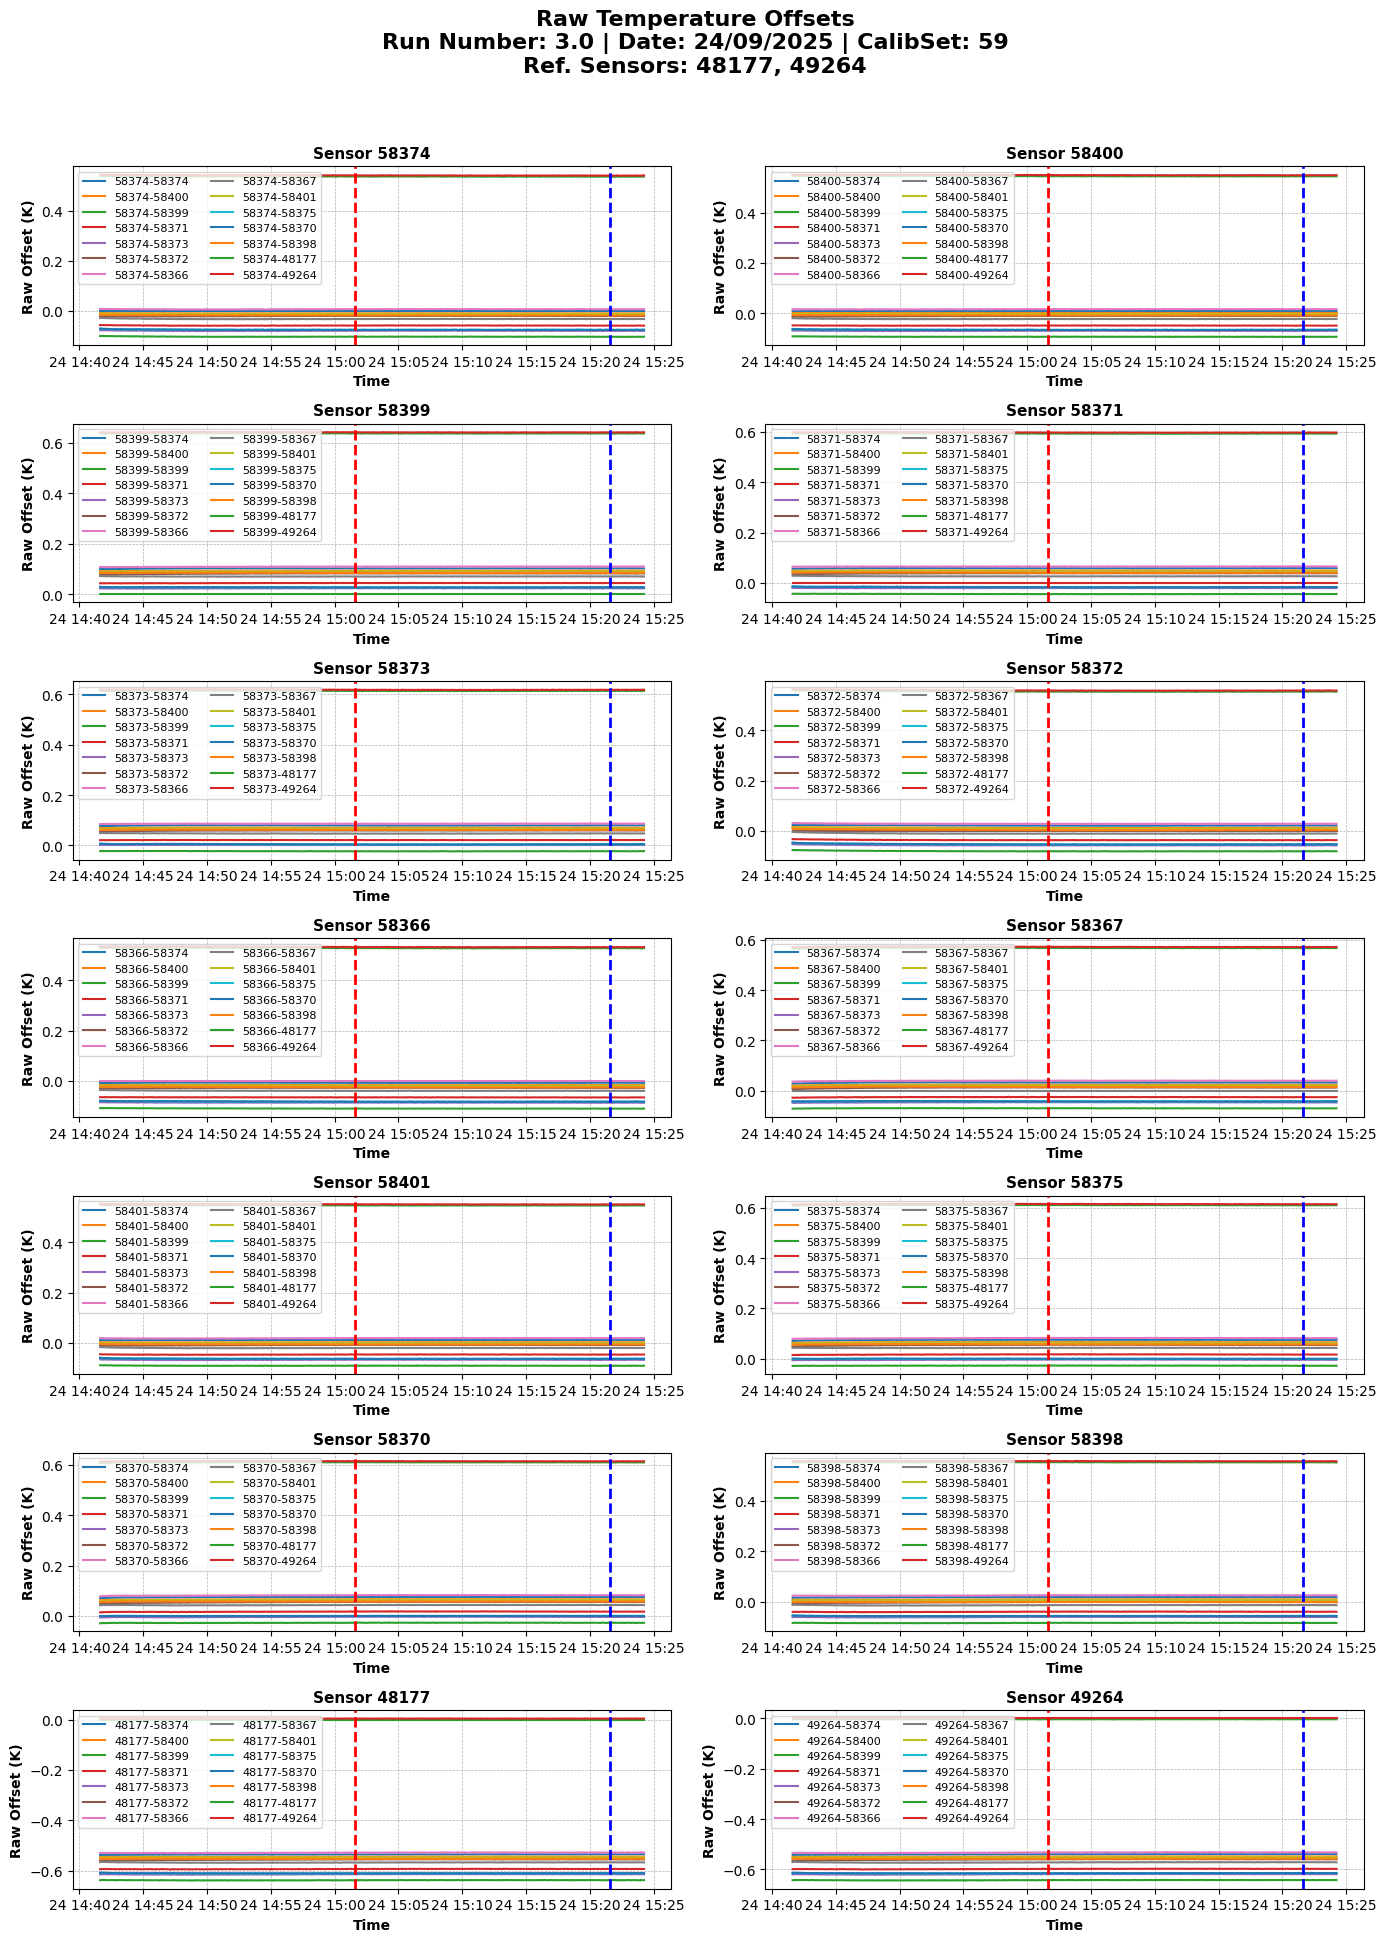

Plots saved in ./Plots/
Gráficos generados y guardados en: ./Plots/


In [ ]:
#output_dir = "./Plots/"

#run.save_control_plots(output_dir=output_dir)

#print(f"Plots generated and saved in: {output_dir}")

In [ ]:
# Calcular offsets
offsets_df = run.offsets()
#print("\nMatriz de Offsets (media entre sensores):")
print(offsets_df)

# Calcular errores (RMS)
errors_df = run.stat_err_offsets()
#print("\nErrores RMS de Offsets:")
print(errors_df)

Offsets medios calculados para los últimos 20 minutos del run.
          58374     58400     58399     58371     58373     58372     58366  \
58374  0.000000 -0.009253 -0.102559 -0.057966 -0.078758 -0.019697  0.007225   
58400  0.009253  0.000000 -0.093307 -0.048713 -0.069505 -0.010444  0.016478   
58399  0.102559  0.093307  0.000000  0.044593  0.023801  0.082862  0.109785   
58371  0.057966  0.048713 -0.044593  0.000000 -0.020792  0.038269  0.065191   
58373  0.078758  0.069505 -0.023801  0.020792  0.000000  0.059061  0.085984   
58372  0.019697  0.010444 -0.082862 -0.038269 -0.059061  0.000000  0.026923   
58366 -0.007225 -0.016478 -0.109785 -0.065191 -0.085984 -0.026923  0.000000   
58367  0.031985  0.022732 -0.070575 -0.025981 -0.046774  0.012287  0.039210   
58401  0.011888  0.002635 -0.090671 -0.046078 -0.066870 -0.007809  0.019113   
58375  0.075347  0.066094 -0.027213  0.017381 -0.003412  0.055649  0.082572   
58370  0.075243  0.065990 -0.027316  0.017277 -0.003515  0.055546  0

Gráfico guardado en: ./Plots/20250924_ln2_r48177_r49264_58374-58398_3_rms_vs_time.png


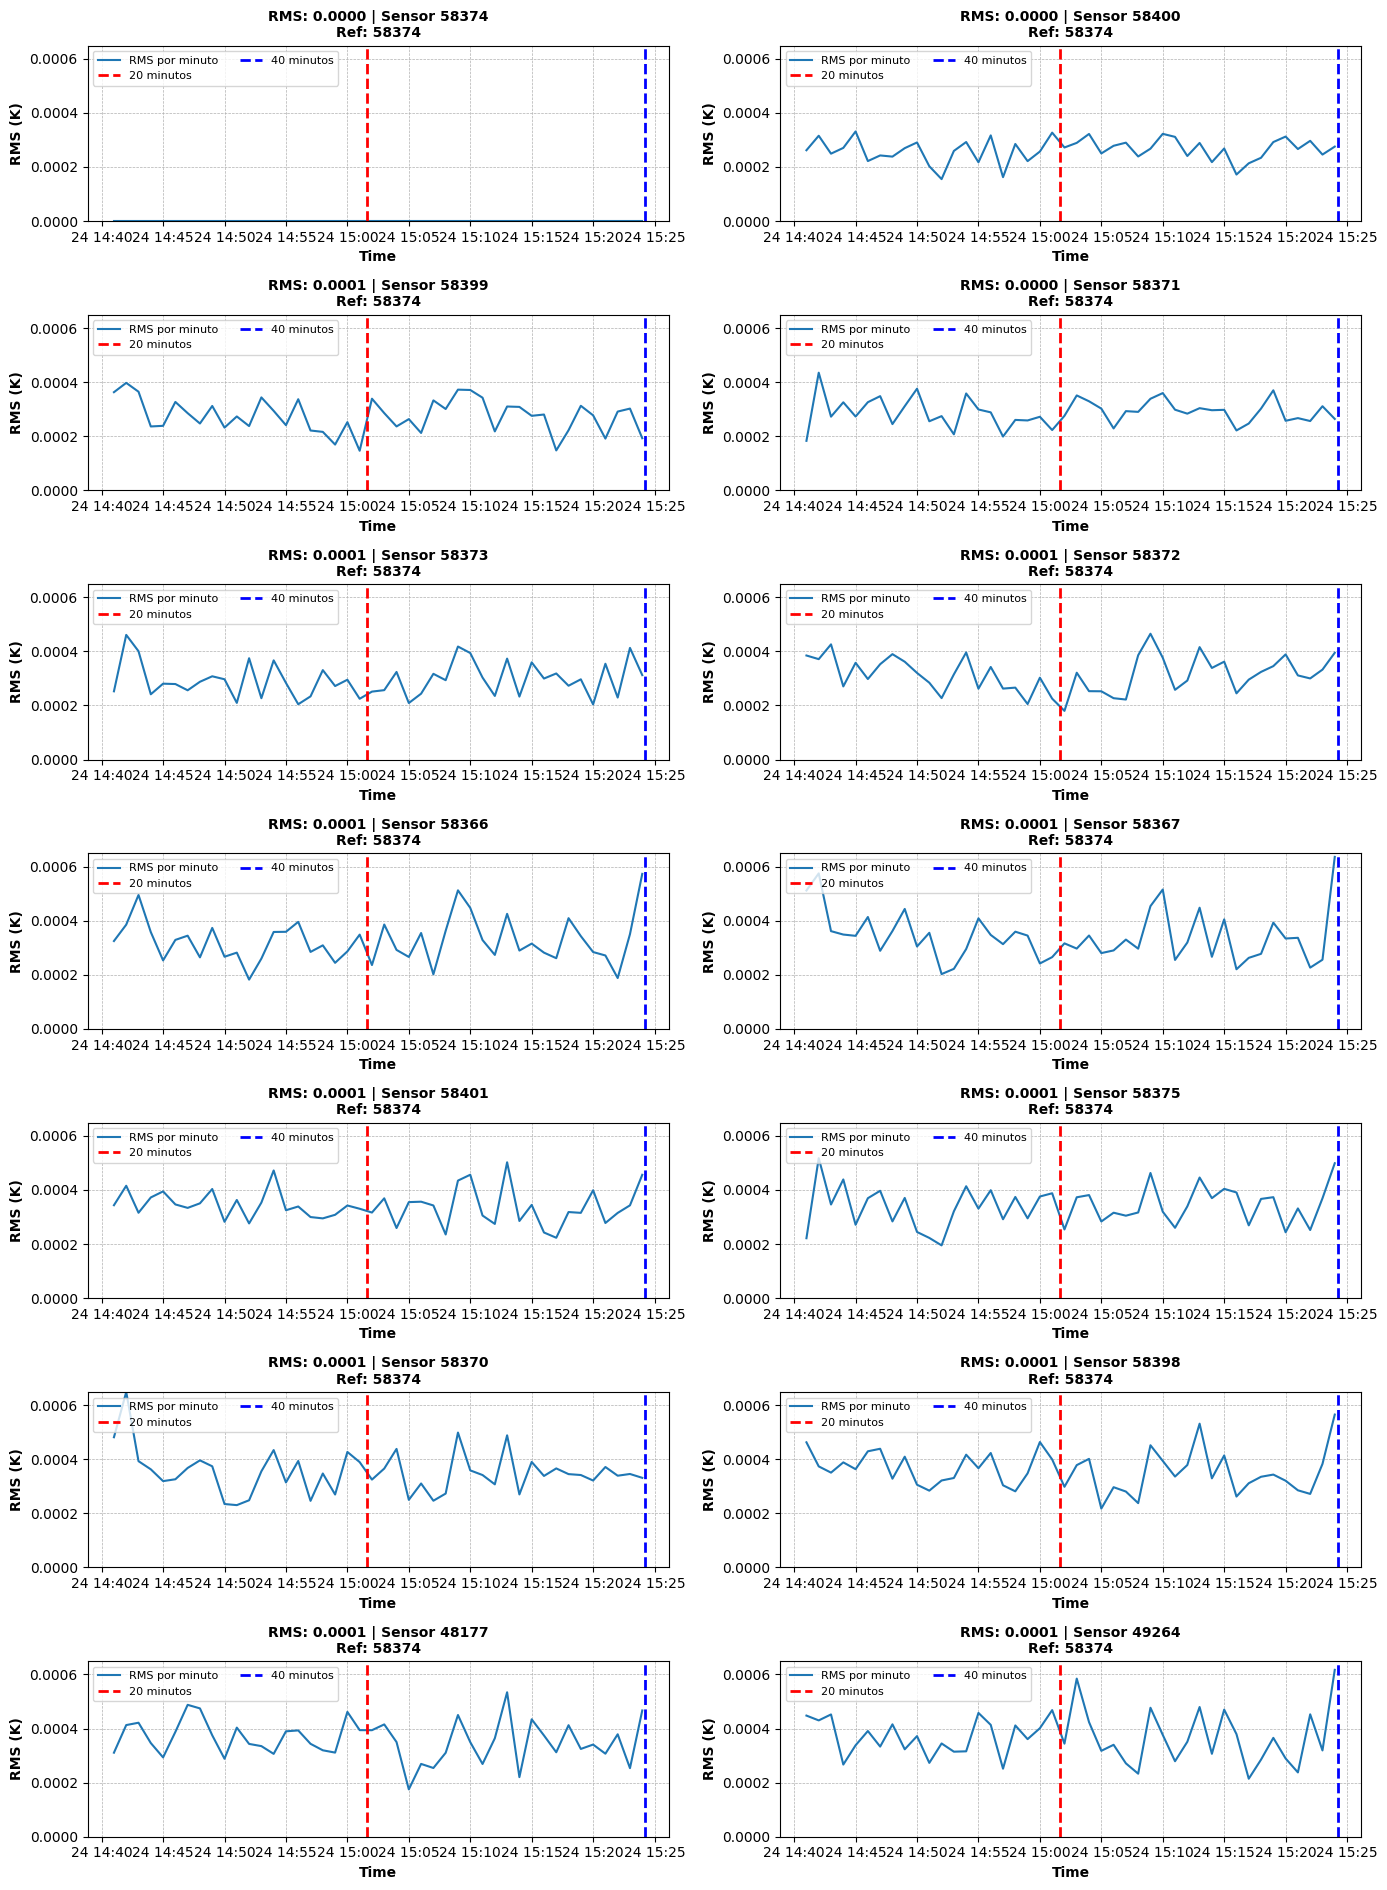

In [ ]:
#run.plot_rms_vs_time(output_dir= "./Plots/")